# Taller 1
## Preguna 1: Construye funciones que realicen todo el proceso que involucra la metodología de Box-Jenkins. 

(i) Presenta el pseudo-código con todo el flujo de programación asociado a la función que estás diseñando.
Identifica claramente cuáles son los inputs requeridos por parte del usuario y el paso a paso de la aplicación
de la metodología de Box-Jenkins.

(ii) Construye una función en el lenguaje de tu preferencia. Esta función, como mínimo, debe:
1. Presentar un gráfico de la serie que se está analizando.
2. Construir y presentar gráficos de la ACF y la PACF.
3. Calcular y presentar los criterios de información AIC y SBC. Ten en cuenta que la fórmula específica
dependerá del método que utilices para estimar el modelo.

Gráfico de la serie:

Warning message:
"package 'gridExtra' is in use and will not be installed"
Warning message:
"package 'TSA' is in use and will not be installed"


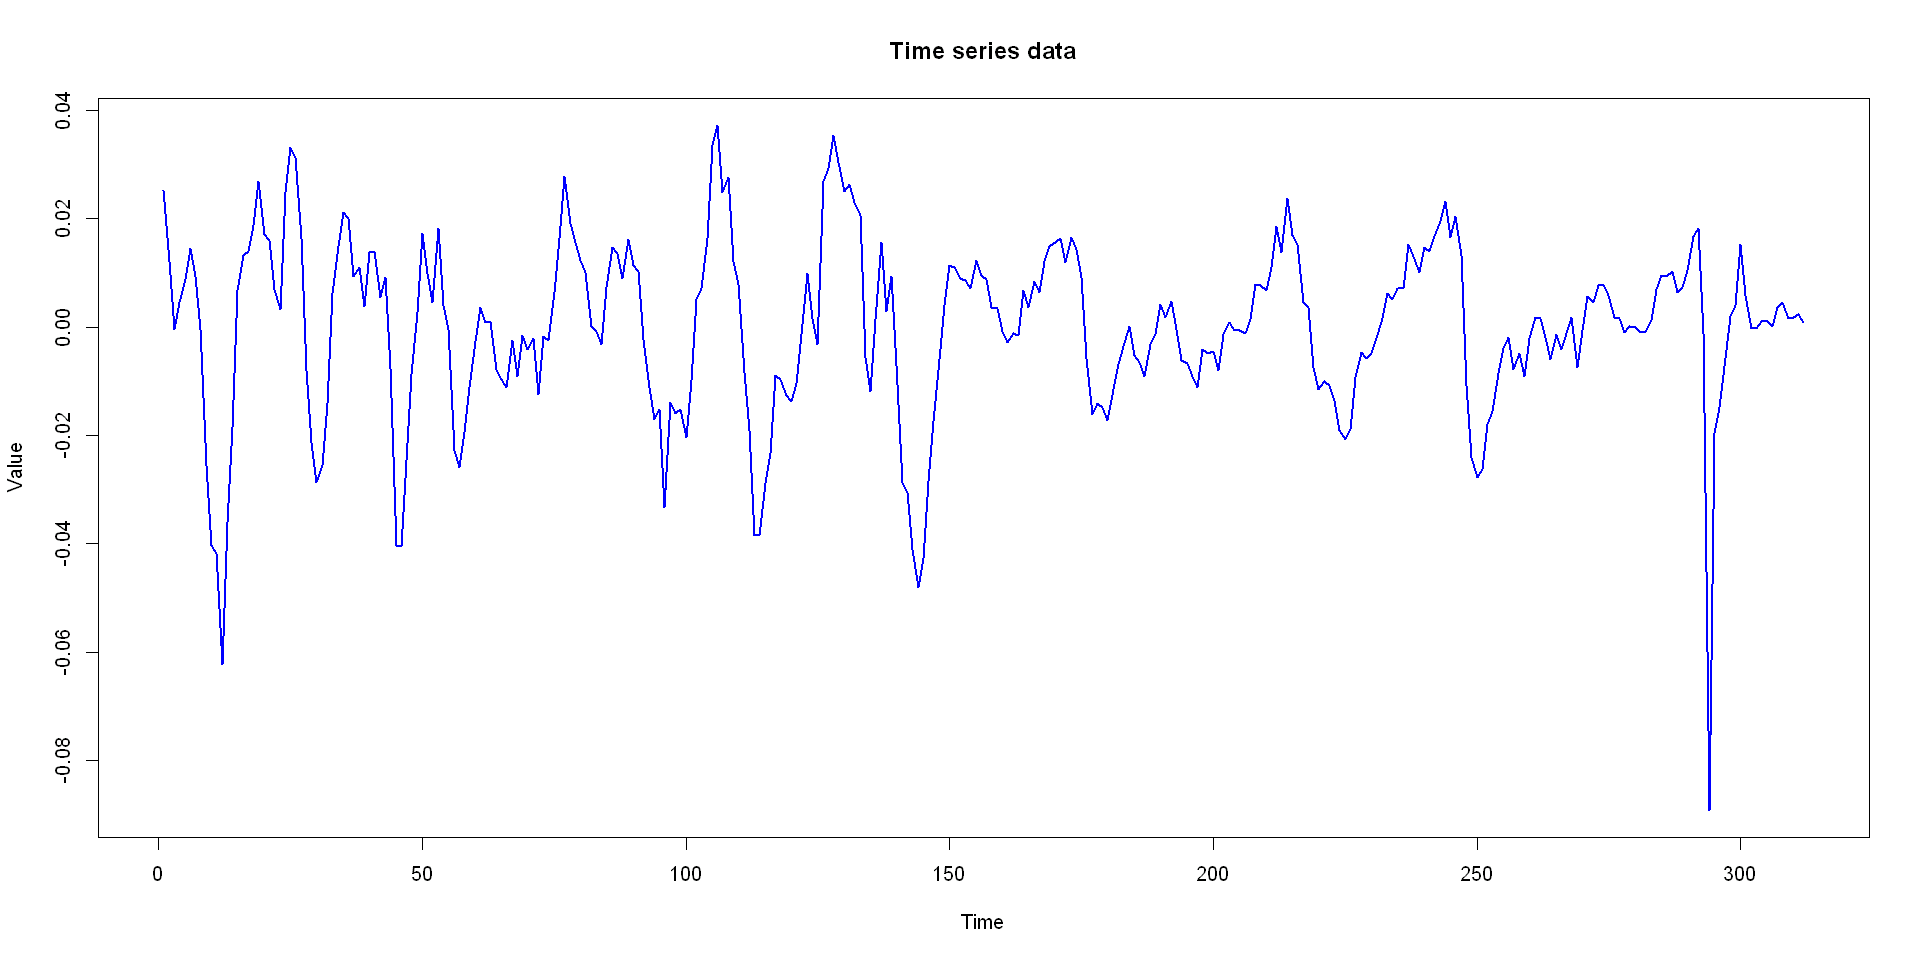

In [6]:
# Working directory:
setwd("C:\\Users\\slbrb\\Desktop\\Universidades\\USFQ\\TeachingAssistant\\202420\\Macro Avanzada\\Talleres\\T1\\data\\serie3")

# Load the data
my_data <- read.csv("serie3_G1.csv", header = TRUE)

# Plot the data
plot(my_data, type = "l", col = "blue", lwd = 2, xlab = "Time", ylab = "Value", main = "Time series data")


install.packages("gridExtra")
install.packages("TSA")

library(TSA)


# Cálculo de ACF y PACF

## 1. Definiciones básicas

Dada una serie temporal $y_t$ con $t = 1,2, \dots, n$, definimos los siguientes términos:

- **Media muestral**:  
  $$ 
  \bar{y} = \frac{1}{n} \sum_{t=1}^{n} y_t 
  $$

- **Varianza muestral**:  
  $$ 
  \sigma^2 = \frac{1}{n} \sum_{t=1}^{n} (y_t - \bar{y})^2 
  $$

- **Covarianza muestral entre $y_t$ y $y_{t-k}$**:  
  $$ 
  \gamma_k = \frac{1}{n} \sum_{t=k+1}^{n} (y_t - \bar{y})(y_{t-k} - \bar{y}) 
  $$

---

## 2. Autocorrelación (ACF)

La función de autocorrelación de un proceso estocástico se define como:

- **Autocorrelación en el rezago $s$**:  
  $$ 
  r_s = \frac{\sum_{t=s+1}^{T} (y_t - \bar{y})(y_{t-s} - \bar{y})}{\sum_{t=1}^{T} (y_t - \bar{y})^2} 
  $$

Donde:
- $y_t$ es la serie de tiempo.
- $\bar{y}$ es la media muestral.
- $s$ es el número de rezagos.

La **ACF** se calcula de manera manual hasta el rezago **máximo de $T/4$**.

### 2.1 Intervalos de Confianza para la ACF

Bajo la hipótesis nula de que $y_t$ sigue un **proceso MA(s-1)**, la varianza de la autocorrelación muestral $r_s$ se calcula como:

- Para $s = 1$:  
  $$ 
  \text{Var}(r_1) = \frac{1}{T} 
  $$

- Para $s > 1$:  
  $$ 
  \text{Var}(r_s) = \frac{1}{T} \left( 1 + 2 \sum_{j=1}^{s-1} r_j^2 \right) 
  $$

---

## 3. Autocorrelación Parcial (PACF)

La función de autocorrelación parcial mide la correlación directa entre $y_t$ y $y_{t-k}$, eliminando la influencia de los rezagos intermedios.

Para calcular la **PACF**:

1. **Primeros valores base**:
   - Para $s = 1$:  
     $$ 
     \phi_{11} = r_1 
     $$
   - Para $s = 2$:  
     $$ 
     \phi_{22} = \frac{r_2 - r_1^2}{1 - r_1^2} 
     $$

2. **Para $s \geq 3$**:  
   $$ 
   \phi_{ss} = \frac{r_s - \sum_{j=1}^{s-1} \phi_{s-1,j} r_{s-j}}{1 - \sum_{j=1}^{s-1} \phi_{s-1,j} r_j} 
   $$

   Y los coeficientes intermedios se actualizan con:  
   $$ 
   \phi_{sj} = \phi_{s-1,j} - \phi_{ss} \phi_{s-1,s-j}, \quad j = 1, 2, \dots, s-1 
   $$

### 3.1 Intervalos de Confianza para la PACF

Bajo la hipótesis nula de que el proceso sigue un **modelo AR(p)**, la varianza de los coeficientes estimados de la PACF es:

  $$ 
  \text{Var}(\hat{\phi}_{p+i,p+i}) \approx \frac{1}{T} 
  $$

Si asumimos normalidad, la PACF es significativa si $|\hat{\phi}_{p+i,p+i}| > 2 / \sqrt{T}$.

---

## 4. Criterios de Información: AIC y BIC

Para comparar modelos, utilizamos los criterios de información **Akaike (AIC)** y **Bayesiano (BIC)**. Dependiendo del método de estimación, sus fórmulas son:

### 4.1 Estimación por Mínimos Cuadrados Ordinarios (MCO)
- **Akaike (AIC) con MCO**:
  $$ 
  AIC = T \ln(\sum e_t^2) + 2n 
  $$
- **Bayesiano (BIC) con MCO**:
  $$ 
  BIC = T \ln(\sum e_t^2) + n \ln(T) 
  $$

Donde:
- $e_t$ son los residuos del modelo.
- $n$ es el número de parámetros estimados ($p + q$ + constante).
- $T$ es el número de observaciones.

### 4.2 Estimación por Máxima Verosimilitud (MLE)
- **Akaike (AIC) con MLE**:
  $$ 
  AIC = -\frac{2 \ln(L)}{T} + \frac{2n}{T} 
  $$
- **Bayesiano (BIC) con MLE**:
  $$ 
  BIC = -\frac{2 \ln(L)}{T} + \frac{n \ln(T)}{T} 
  $$

Donde $L$ es la verosimilitud maximizada del modelo.

---

## 5. Prueba de Ljung-Box para Residuales

Para evaluar si los residuos de un modelo son ruido blanco, utilizamos la **prueba de Ljung-Box**, basada en la estadística:

$$ 
Q = T (T + 2) \sum_{k=1}^{s} \frac{r_k^2}{T - k} 
$$

Donde:
- $r_k$ es la autocorrelación de los residuos en el rezago $k$.
- $T$ es el número total de observaciones.
- $s$ es el número de rezagos utilizados en la prueba.

El valor de $Q$ se compara con una distribución $\chi^2$ con $s$ grados de libertad. Si $Q$ es grande y el valor $p$ es pequeño, rechazamos la hipótesis nula de que los residuos son ruido blanco.

---

## 6. Selección de Modelos ARMA

Los modelos AR, MA y ARMA se seleccionan según los rezagos significativos en ACF y PACF:

- **Si la ACF decae exponencialmente y la PACF se corta en $p$, sugerimos un modelo AR(p).**
- **Si la PACF decae exponencialmente y la ACF se corta en $q$, sugerimos un modelo MA(q).**
- **Si ni ACF ni PACF muestran un corte claro, sugerimos un modelo ARMA(p, q).**

El modelo óptimo se elige minimizando AIC o BIC.

---

## 7. Evaluación de los Residuos

Para verificar si los residuos del modelo son **ruido blanco**, se analizan sus propiedades estadísticas y su estructura de correlación. Un modelo adecuado debe producir residuos no correlacionados y con distribución aproximadamente normal.

### 7.1 Análisis de la Media y Varianza de los Residuos

Si los residuos son ruido blanco, deberían cumplir que:

- La **media de los residuos** es cercana a **cero**:
  
  $$ \bar{e} = \frac{1}{T} \sum_{t=1}^{T} e_t \approx 0 $$

- La **varianza de los residuos** es constante en el tiempo (**homocedasticidad**):

  $$ \sigma_e^2 = \frac{1}{T} \sum_{t=1}^{T} (e_t - \bar{e})^2 $$

Si se observan cambios sistemáticos en la varianza, esto sugiere la presencia de heterocedasticidad.

### 7.2 Función de Autocorrelación (ACF) y Autocorrelación Parcial (PACF) de los Residuos

Se analizan los gráficos de ACF y PACF de los residuos para identificar la presencia de correlación en diferentes rezagos:

- Si los residuos son **ruido blanco**, los valores de ACF y PACF deberían ser cercanos a **cero** y no presentar patrones significativos.
- Si los valores de ACF o PACF superan los intervalos de confianza, puede indicar que el modelo no capturó toda la estructura de la serie.


In [24]:
# Función para calcular la ACF y PACF y compararla con las funciones de R
acf_pacf_manual <- function(series, plot = TRUE, crit_info = TRUE) {
    library(ggplot2)
    library(gridExtra)
    library(dplyr)
    library(tidyr)
    library(kableExtra)

    # Convertir a vector numérico en caso de que sea data.frame o lista
    if (is.data.frame(series)) {
        series <- as.numeric(series[[2]]) # Selecciona la columna con datos
    } else {
        series <- as.numeric(series) # Convierte cualquier otro formato a numérico
    }

    T <- length(series)
    max_lag <- floor(T / 4) # Número máximo de rezagos a calcular

    # Cálculo media
    mean_y <- mean(series)

    # Cálculo varianza
    var_y <- var(series)

    # Cálculo manual de la ACF
    acf_values <- numeric(max_lag)
    for (s in 1:max_lag) {
        numerator <- sum((series[(s + 1):T] - mean_y) * (series[1:(T - s)] - mean_y))
        denominator <- sum((series - mean_y)^2)
        acf_values[s] <- numerator / denominator
    }

    # Cálculo de los intervalos de confianza para la ACF
    acf_var <- numeric(max_lag)
    acf_var[1] <- 1 / T # Para s = 1
    for (s in 2:max_lag) {
        acf_var[s] <- (1 / T) * (1 + 2 * sum(acf_values[1:(s - 1)]^2))
    }
    acf_sd <- sqrt(acf_var)
    acf_threshold_value <- min(acf_sd[-1]) * 2

    # Identificar rezagos significativos para la ACF
    significant_acf_lags <- which(abs(acf_values) > acf_threshold_value)

    # Cálculo manual de la PACF 
    pacf_values <- numeric(max_lag)
    phi <- matrix(0, nrow = max_lag, ncol = max_lag) # Matriz de coeficientes parciales

    # Caso base: el primer coeficiente PACF es la primera ACF
    pacf_values[1] <- acf_values[1]
    phi[1, 1] <- acf_values[1]

    pacf_values[1] <- acf_values[1] # Caso base
    phi[1, 1] <- acf_values[1]

    for (s in 2:max_lag) {
        if (s == 2) {
            phi[s, s] <- (acf_values[s] - acf_values[1]^2) / (1 - acf_values[1]^2)
        } else {
            sum_num <- sum(phi[s - 1, 1:(s - 1)] * acf_values[rev(1:(s - 1))])
            sum_den <- sum(phi[s - 1, 1:(s - 1)] * acf_values[1:(s - 1)])
            phi[s, s] <- (acf_values[s] - sum_num) / (1 - sum_den)
        }

        for (j in 1:(s - 1)) {
            phi[s, j] <- phi[s - 1, j] - phi[s, s] * phi[s - 1, s - j]
        }

        pacf_values[s] <- phi[s, s]
    }

    # Intervalos de confianza para la PACF, 95% de confianza
    pacf_threshold <- 2 * (T^(-0.5))

    # Identificar rezagos significativos para la PACF
    significant_pacf_lags <- which(abs(pacf_values) > pacf_threshold)

    # Comparación con funciones de R
    acf_r <- acf(series, lag.max = max_lag + 1, plot = FALSE)$acf
    pacf_r <- pacf(series, lag.max = max_lag + 1, plot = FALSE)$acf

    # Definir el tamaño mínimo entre los cálculos manuales y las funciones de R
    common_lag <- min(length(acf_values), length(acf_r), length(pacf_values), length(pacf_r))

    # Ajustar el tamaño de los vectores para que coincidan
    acf_values <- acf_values[1:common_lag]
    pacf_values <- pacf_values[1:common_lag]
    acf_r <- acf_r[1:common_lag]
    pacf_r <- pacf_r[1:common_lag]

    # Crear la tabla de comparación con los valores ajustados
    comparison_table <- data.frame(
        Lag = 1:common_lag,
        ACF_Manual = round(acf_values, 4),
        ACF_R = round(acf_r, 4),
        PACF_Manual = round(pacf_values, 4),
        PACF_R = round(pacf_r, 4)
    )

    # print(comparison_table, row.names = FALSE, quote = FALSE)

    # Crear una tabla con los rezagos significativos
    significant_lags_table <- data.frame(
        Lag = c(significant_acf_lags, significant_pacf_lags),
        Type = c(rep("ACF", length(significant_acf_lags)), rep("PACF", length(significant_pacf_lags)))
    )

    # Imprimir la tabla de rezagos significativos si existen
    if (nrow(significant_lags_table) > 0) {
        # cat("\nRezagos Significativos en ACF y PACF:\n")
        # print(significant_lags_table, row.names = FALSE, quote = FALSE)
    } else {
        cat("\nNo hay rezagos significativos detectados en ACF o PACF.\n")
    }

    if (plot) {
        # Función para graficar la comparación
        plot_comparison <- function(manual_values, r_values, title) {
            df <- data.frame(Lag = 1:max_lag, Manual = manual_values, R_Function = r_values)

            ggplot(df, aes(x = Lag)) +
                geom_line(aes(y = Manual, color = "Manual"), linewidth = 1) +
                geom_line(aes(y = R_Function, color = "R Function"), linewidth = 1, linetype = "dashed") +
                theme_minimal() +
                labs(title = title, x = "Rezago", y = "Valor") +
                theme(plot.title = element_text(hjust = 0.5))
        }

        # Crear gráficos de comparación
        plot_acf_comparison <- plot_comparison(acf_values, acf_r, "Comparación ACF")
        plot_pacf_comparison <- plot_comparison(pacf_values, pacf_r, "Comparación PACF")

        # Ajustar tamaño del gráfico
        options(repr.plot.width = 16, repr.plot.height = 8)

        # Mostrar gráficos comparativos
        # grid.arrange(plot_acf_comparison, plot_pacf_comparison, ncol = 2)

        # Graficar la ACF
        acf_plot <- ggplot(data.frame(Lag = 1:max_lag, ACF = acf_values), aes(x = Lag, y = ACF)) +
            geom_bar(stat = "identity", fill = "blue", color = "black") +
            geom_hline(yintercept = c(-acf_threshold_value, acf_threshold_value), linetype = "dashed", color = "red") +
            theme_minimal() +
            labs(title = "Función de Autocorrelación (ACF)", x = "Rezago", y = "ACF") +
            theme(plot.title = element_text(hjust = 0.5))

        # Graficar la PACF
        pacf_plot <- ggplot(data.frame(Lag = 1:max_lag, PACF = pacf_values), aes(x = Lag, y = PACF)) +
            geom_bar(stat = "identity", fill = "green", color = "black") +
            geom_hline(yintercept = c(-pacf_threshold, pacf_threshold), linetype = "dashed", color = "red") +
            theme_minimal() +
            labs(title = "Función de Autocorrelación Parcial (PACF)", x = "Rezago", y = "PACF") +
            theme(plot.title = element_text(hjust = 0.5))

        grid.arrange(pacf_plot, acf_plot, ncol = 2)

    }   

    # Definir modelos candidatos
    models <- list()
    model_names <- c()

    # Modelos AR(p)
    if (length(significant_pacf_lags) > 0) {
        for (p in head(significant_pacf_lags,3)) {
            model_name <- paste0("AR(", p, ")")
            models[[model_name]] <- arima(series, order = c(p, 0, 0))
            model_names <- c(model_names, model_name)
        }
    }

    # Modelos MA(q)
    if (length(significant_acf_lags) > 0) {
        for (q in head(significant_acf_lags, 3)) {
            model_name <- paste0("MA(", q, ")")
            models[[model_name]] <- arima(series, order = c(0, 0, q))
            model_names <- c(model_names, model_name)
        }
    }

    # Modelos ARMA(p, q)
    if (length(significant_pacf_lags) > 0 & length(significant_acf_lags) > 0) {
        for (p in head(significant_pacf_lags, 3)) {
            for (q in head(significant_acf_lags, 3)) {
                model_name <- paste0("ARMA(", p, ",", q, ")")
                models[[model_name]] <- arima(series, order = c(p, 0, q))
                model_names <- c(model_names, model_name)
            }
        }
    }

    # Crear tabla de resultados
    results <- data.frame()
    coefficients_list <- list()
    Q_stats <- c(NA, NA, NA)

    i <- 1
    for (model_name in names(models)) {
        model <- models[[model_name]]
        residuals <- residuals(model)
        sigma_sq <- sum(residuals^2) / T
        log_lik_r <- as.numeric(logLik(model))

        n_params <- length(coef(model))
        aic_mco <- T * log(sigma_sq) + 2 * n_params
        bic_mco <- T * log(sigma_sq) + n_params * log(T)
        aic_mle <- (-2 * log_lik_r) / T + (2 * n_params) / T
        bic_mle <- (-2 * log_lik_r) / T + (n_params * log(T)) / T
        aic_r <- AIC(model)
        bic_r <- BIC(model)

        # Guardar coeficientes del modelo
        coefficients_list[[model_name]] <- coef(model)

        # Calcular Q para los residuos de cada modelo
        if (length(significant_acf_lags) > 0 || length(significant_pacf_lags) > 0) {
            Q_stats <- sapply(c(8, 16, 24), function(s) {
                sum((acf(residuals, plot = FALSE, lag.max = s)$acf)^2 / (T - (1:s))) * T * (T + 2)
            })
            p_values <- 1 - pchisq(Q_stats, df = c(8, 16, 24))
        } else {
            Q_stats <- c(NA, NA, NA)
            cat("\nNo hay rezagos significativos, el estadístico Q de Ljung-Box no se calcula.\n")
        }
        
        results <- rbind(results, data.frame(
            Model = model_names[i],
            AIC_MCO = round(aic_mco, 2),
            BIC_MCO = round(bic_mco, 2),
            AIC_MLE = round(aic_mle, 2),
            BIC_MLE = round(bic_mle, 2),
            # AIC_R = round(aic_r, 2),
            # BIC_R = round(bic_r, 2),
            Ljung_Box_Q8 = paste0(round(Q_stats[1], 2), " (", round(p_values[1], 3), ")"),
            Ljung_Box_Q16 = paste0(round(Q_stats[2], 2), " (", round(p_values[2], 3), ")"),
            Ljung_Box_Q24 = paste0(round(Q_stats[3], 2), " (", round(p_values[3], 3), ")")
        ))
        i <- i + 1
    }

    # Mostrar tabla de resultados
    if (crit_info) {
        cat("\n\nResultados estimaciones AIC y BIC:\n")
        print(results, row.names = FALSE, quote = FALSE)
        # print(tabla_latex)
    }    

    return(list(
        ACF_Manual = acf_values,
        PACF_Manual = pacf_values,
        ACF_R = acf_r,
        PACF_R = pacf_r,
        Models = models, 
        Residuals = lapply(models, residuals),
        Coefficients = coefficients_list,
        Q_Estadistico = Q_stats
    ))
}



Resultados estimaciones AIC y BIC:
     Model  AIC_MCO  BIC_MCO AIC_MLE BIC_MLE  Ljung_Box_Q8 Ljung_Box_Q16
     AR(1) -2864.31 -2856.82   -6.34   -6.32  26.3 (0.001) 36.16 (0.003)
     AR(2) -2872.68 -2861.45   -6.37   -6.33 13.55 (0.094) 22.61 (0.125)
     AR(3) -2882.10 -2867.13   -6.40   -6.35  4.28 (0.831) 14.07 (0.593)
     MA(1) -2756.27 -2748.78   -5.99   -5.97    151.02 (0)    224.27 (0)
     MA(2) -2832.50 -2821.27   -6.24   -6.20     60.04 (0)     95.88 (0)
     MA(3) -2863.56 -2848.59   -6.34   -6.29 22.88 (0.004)     43.31 (0)
 ARMA(1,1) -2869.32 -2858.09   -6.36   -6.32 16.74 (0.033) 25.87 (0.056)
 ARMA(1,2) -2875.71 -2860.73   -6.38   -6.33  8.96 (0.346) 17.44 (0.358)
 ARMA(1,3) -2876.77 -2858.05   -6.38   -6.32  6.22 (0.622) 14.76 (0.542)
 ARMA(2,1) -2916.67 -2901.70   -6.49   -6.45  3.27 (0.916) 12.09 (0.738)
 ARMA(2,2) -2914.76 -2896.05   -6.49   -6.43  3.01 (0.934)  11.46 (0.78)
 ARMA(2,3) -2914.13 -2891.67   -6.49   -6.41  0.86 (0.999)  8.72 (0.925)
 ARMA(3,1) -29

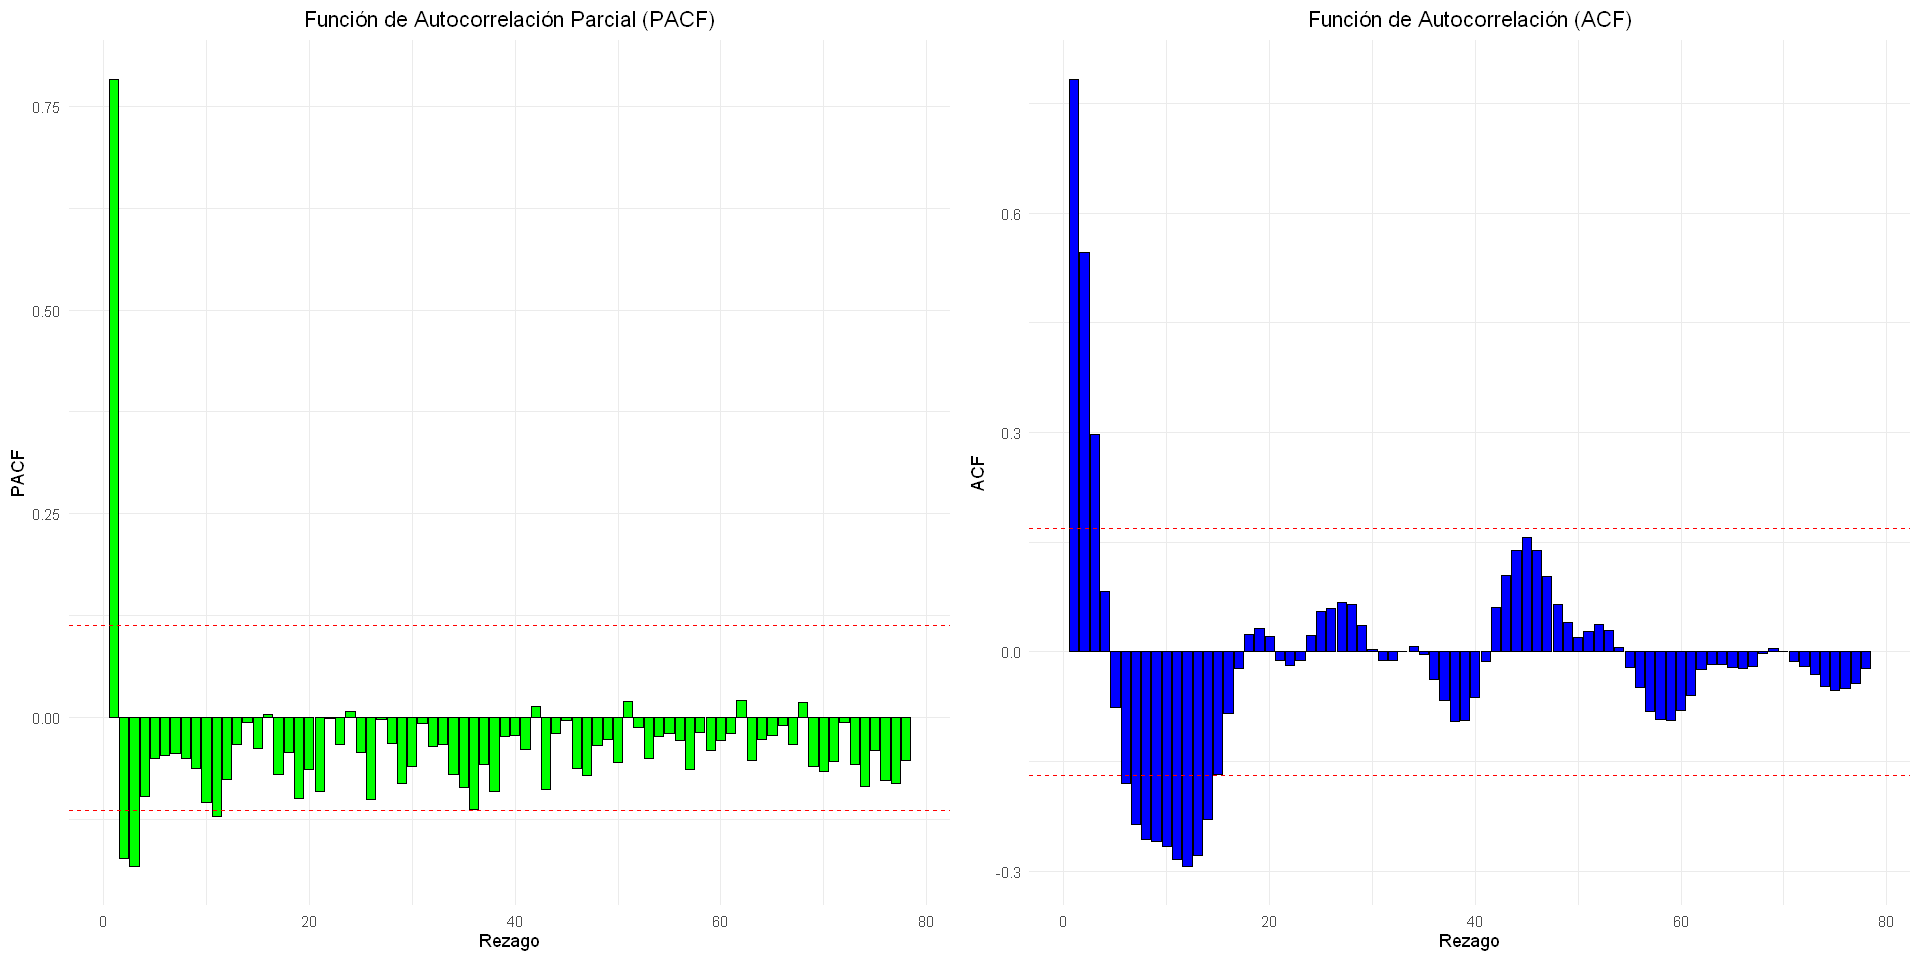

In [25]:
# Usar la función para calcular la ACF y PACF
results <- acf_pacf_manual(my_data$y, plot = TRUE, crit_info = TRUE)

In [9]:
# Comparar con estimaciones de paquetes de R

# Cargar paquetes necesarios
library(forecast)
library(TSA)

# Comparar con estimaciones de R
cat("\n---- Estimaciones ACF y PACF usando función eacf:\n")
eacf(my_data$y)

cat("\n---- Estimaciones ACF y PACF usando función ar:\n")
modelo_ar <- ar(my_data$y, aic = TRUE, method = "mle")
cat("Orden óptimo de AR(p) sugerido:", modelo_ar$order, "\n\n")

cat("---- Estimaciones ACF y PACF usando función auto.arima:\n")
modelo_auto <- auto.arima(my_data$y)
print(summary(modelo_auto))


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'forecast':
  method       from
  fitted.Arima TSA 
  plot.Arima   TSA 




---- Estimaciones ACF y PACF usando función eacf:
AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x x x o o x x x x x x  x  x  x 
1 x x x o o x o o o o o  o  o  o 
2 x o o o o o o o o o o  o  o  o 
3 x o o o o o o o o o o  o  o  o 
4 x o o o o o o o o o o  o  o  o 
5 x o o o o o o o o o o  o  o  o 
6 x x o x o o o o o o o  o  o  o 
7 x o x o o o o o o o o  o  o  o 

---- Estimaciones ACF y PACF usando función ar:
Orden óptimo de AR(p) sugerido: 12 

---- Estimaciones ACF y PACF usando función auto.arima:
Series: my_data$y 
ARIMA(3,0,0) with zero mean 

Coefficients:
         ar1      ar2      ar3
      0.8950  -0.0052  -0.1889
s.e.  0.0556   0.0753   0.0556

sigma^2 = 9.578e-05:  log likelihood = 1001.77
AIC=-1995.53   AICc=-1995.4   BIC=-1980.56

Training set error measures:
                        ME        RMSE         MAE      MPE    MAPE      MASE
Training set -1.040973e-05 0.009739576 0.006011133 20.86281 162.484 0.8965338
                    ACF1
Training set -0.02256991


(iii) Construye otra función que, dado el modelo seleccionado, calcule los residuos y compruebe si son ruido
blanco. Además, esta función debe calcular los errores de predicción para los horizontes especificados por el
usuario.

## 8. Evaluación de la Precisión del Modelo

Para evaluar la precisión de las predicciones, se calculan los **errores de predicción** en diferentes horizontes.

### 8.1 Predicciones a Diferentes Horizontes

El modelo realiza predicciones en **horizontes específicos**:

$$
\hat{y}_{T+h} = f(y_T, y_{T-1}, \dots)
$$

Donde:
- $ \hat{y}_{T+h} $ es la predicción para el horizonte $ h $.
- $ y_T, y_{T-1}, \dots $ son los valores históricos de la serie.

Se evalúan los errores de predicción en los **horizontes seleccionados**.

### 8.2 Cálculo de los Errores de Predicción

Se utilizan las siguientes métricas para evaluar la precisión del modelo:

#### 8.2.1 Error Absoluto Medio (MAE)

$$
MAE = \frac{1}{H} \sum_{h=1}^{H} |y_{T+h} - \hat{y}_{T+h}|
$$

Mide el error promedio absoluto entre las predicciones y los valores reales.

#### 8.2.2 Raíz del Error Cuadrático Medio (RMSE)

$$
RMSE = \sqrt{\frac{1}{H} \sum_{h=1}^{H} (y_{T+h} - \hat{y}_{T+h})^2}
$$

El RMSE penaliza más los errores grandes que el MAE.

Donde:
- $ y_{T+h} $ es el valor real en el horizonte $ h $.
- $ \hat{y}_{T+h} $ es el valor predicho en el horizonte $ h $.
- $ H $ es el número total de horizontes de predicción evaluados.

---

## 9. Visualización de Resultados

Para facilitar el análisis, se puede recurir los siguientes gráficos:

1. **Histograma de Residuos**:  
  Permite observar la distribución de los residuos.
   
2. **Gráficos de ACF y PACF de los Residuos**:  
  Identifican patrones de correlación en los residuos.

3. **Comparación de Predicciones vs. Valores Reales**:  
  Mostrar la evolución de la serie original y sus predicciones.

In [31]:
analisis_residuos_prediccion <- function(series, p, d, q, H, alpha = 0.95, plot = TRUE) {
    library(ggplot2)
    library(gridExtra)
    library(dplyr)
    library(tidyr)
    library(forecast)
    library(TSA)

    T <- length(series)

    # Convertir la serie en un vector numérico en caso de que sea un objeto ts
    series <- as.numeric(series)

    # Ajustar el modelo ARIMA completo para extraer residuos
    model <- Arima(series, order = c(p, d, q))

    # Extraer residuos del modelo
    residuos <- residuals(model)

    # Calcular estadísticas básicas de los residuos
    mean_res <- mean(residuos)
    var_res <- var(residuos)

    cat("\nMedia de los residuos:", mean_res)
    cat("\nVarianza de los residuos:", var_res, "\n")

    # Calcular ACF y PACF manualmente sin generar gráficos
    acf_pacf_residuos <- acf_pacf_manual(residuos, plot = FALSE, crit_info = FALSE)

    # Extraer el estadístico Q de Ljung-Box
    if (!all(is.na(acf_pacf_residuos$Q_Estadistico))) {
        cat("\nEstadístico Q de Ljung-Box para residuos:\n")
        print(acf_pacf_residuos$Q_Estadistico)
    } else {
        cat("\nNo se calculó el estadístico Q de Ljung-Box porque no hay rezagos significativos.\n")
    }

    # Histograma de los residuos con distribución normal superpuesta
    hist_residuos <- ggplot(data.frame(Residuos = residuos), aes(x = Residuos)) +
        geom_histogram(aes(y = after_stat(density)), fill = "gray", color = "black", bins = 30) +
        stat_function(fun = dnorm, args = list(mean = mean_res, sd = sqrt(var_res)), color = "red", linetype = "dashed") +
        theme_minimal() +
        labs(title = "Histograma de los Residuos con Distribución Normal", x = "Residuos", y = "Densidad")

    # Predicción dentro de la muestra (eliminando los últimos H valores)
    series_train <- series[1:(T - H)]
    model_train <- Arima(series_train, order = c(p, d, q))

    # Predicción de los últimos H valores
    pred <- predict(model_train, n.ahead = H)
    pred_values <- pred$pred
    pred_se <- pred$se

    # Calcular los errores de predicción
    errores <- series[(T - H + 1):T] - pred_values
    MSPE <- mean(errores^2)

    # Construcción de intervalos de confianza
    z_value <- qnorm(1 - (1 - alpha) / 2)
    lower_bound <- pred_values - z_value * pred_se
    upper_bound <- pred_values + z_value * pred_se

    # DataFrame para visualización de predicción
    df_pred <- data.frame(
        Time = (T - H + 1):T,
        Observado = series[(T - H + 1):T],
        Predicho = pred_values,
        Lower = lower_bound,
        Upper = upper_bound
    )

    # Crear un DataFrame con toda la serie y las predicciones
    df_full <- data.frame(
        Time = 1:T,
        Observado = series,
        Predicho = c(rep(NA, T - H), pred_values),
        Lower = c(rep(NA, T - H), lower_bound),
        Upper = c(rep(NA, T - H), upper_bound)
    )

    # Gráfico de la serie original y la predicción usando toda la serie
    pred_plot <- ggplot(df_full, aes(x = Time)) +
        geom_line(aes(y = Observado, color = "Observado"), linewidth = 1) +
        geom_line(aes(y = Predicho, color = "Predicho"), linewidth = 1, linetype = 1) +
        geom_ribbon(aes(ymin = Lower, ymax = Upper), alpha = 0.2, fill = "blue") +
        theme_minimal() +
        labs(title = "Predicción dentro de la Muestra", x = "Tiempo", y = "Valor") +
        theme(plot.title = element_text(hjust = 0.5))

    # Mostrar gráficos
    if (plot) {
        print(hist_residuos)
        print(pred_plot)
    }

    # Devolver resultados
    return(list(
        Residuos = residuos,
        Media_Residuos = mean_res,
        Varianza_Residuos = var_res,
        ACF_Residuos = acf_pacf_residuos$ACF_Manual,
        PACF_Residuos = acf_pacf_residuos$PACF_Manual,
        Q_Estadistico = acf_pacf_residuos$Q_Estadistico,
        Errores = errores,
        MSPE = MSPE,
        Predicciones = df_pred
    ))
}



Media de los residuos: 0.0001095876
Varianza de los residuos: 8.477331e-05 

No hay rezagos significativos detectados en ACF o PACF.

No se calculó el estadístico Q de Ljung-Box porque no hay rezagos significativos.


Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Warning message:
"Removed 304 rows containing missing values or values outside the scale range
(`geom_line()`)."


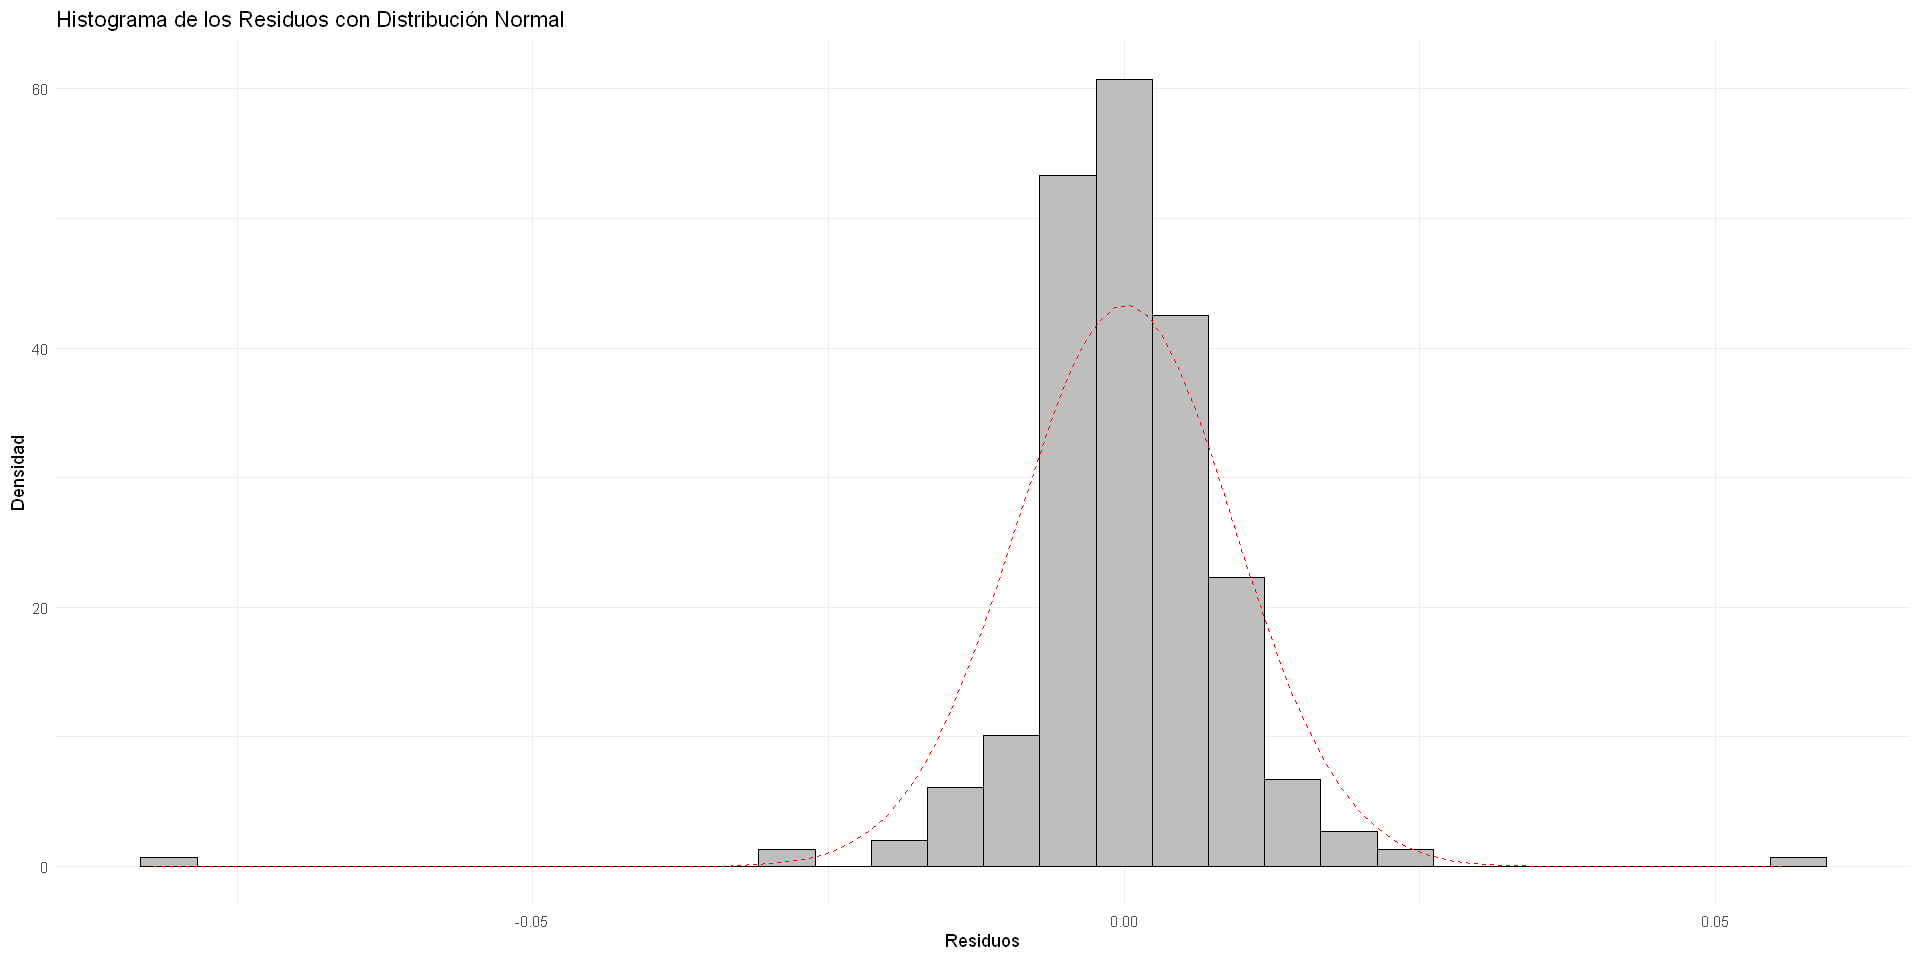

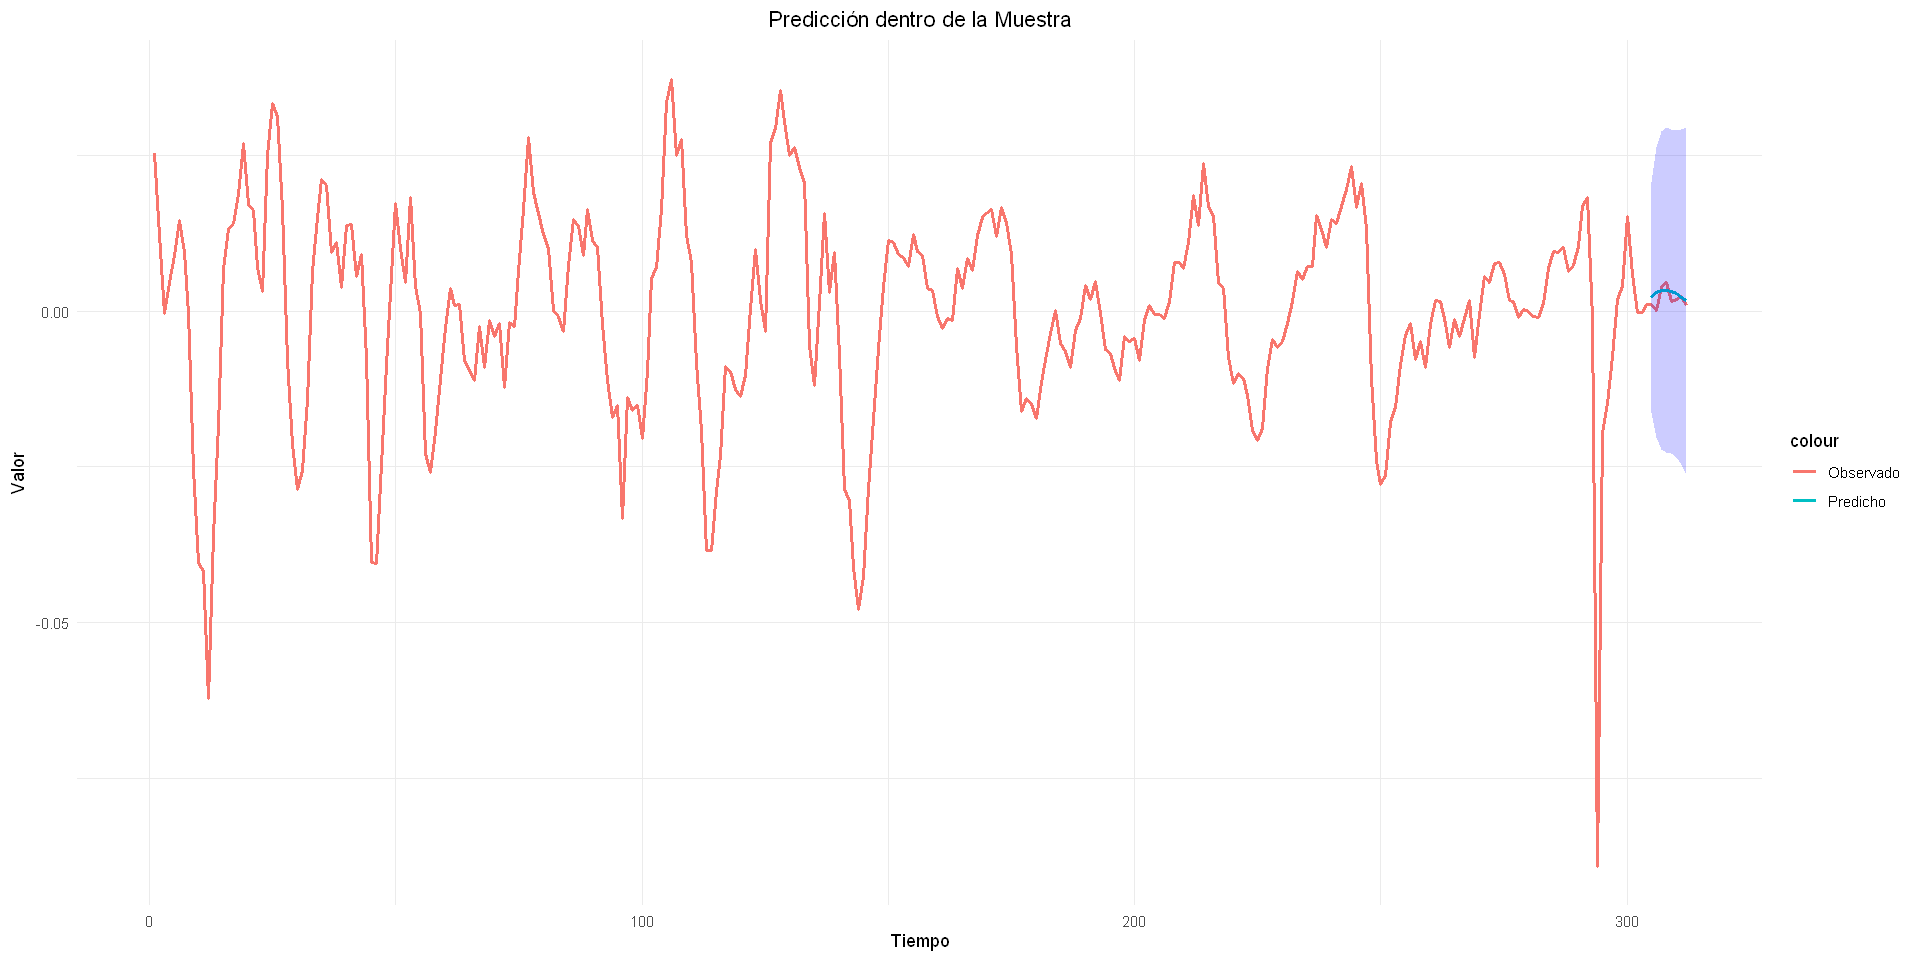

In [32]:
# Estimar usando la funcion analisis_residuos_prediccion
results2 <- analisis_residuos_prediccion(my_data$y, p = 3, d = 0, q = 3, H = 8)
